In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

### Experiment Parameters

In [35]:
experiment = {
    'TYPE': 'test',        # Experiment type: 'train', 'test'
    'IMAGE_SIZE': (512, 512),
    'INPUT_SHAPE': (512, 512, 3),
    'TEST_SIZE': 0.1,       # Test data size: All Test Data / All Data
    'DATA_AUG': True,       # Apply data augmentation

    'ACCELERATOR': 'GPU',  # Or 'TPU'

    'BACKBONE': 'custom', # Or 'custom' TODO: Add ResNet model
    'BATCH_SIZE': 16,
    'EPOCHS': 1000,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 0.0001,  # 1e-4
    'PERP_LOSS_LAMBDA': 1,
    'RECONS_LOSS': 'PERCEPTUAL',     # reconstruction loss ('SSIM', 'MSE', 'MAE', 'PERCEPTUAL')
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value
    'MSE_LOSS_LAMBDA': 0.01,  # MSE coeff
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'SAVE_WEIGHTS_PER_EPOCH': 20,

    # set the dimensionality of the latent space to a plane for visualization later
    'LATENT_DIM': 500,

    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "tf_vae/BD67_dataset/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "tf_vae/BD67_dataset/images",
}

In [3]:
import zipfile

# Unzip the downloaded file
def unzip_data(zip_file_name, dest):
  zip_ref = zipfile.ZipFile(zip_file_name, "r")
  zip_ref.extractall(dest)
  zip_ref.close()

In [4]:
# DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset.zip'
# unzip_data(DATASET_PATH, ROOT_PATH)

In [5]:
ROOT_PATH = '/content'
DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset'

In [6]:
import os

BD67_NORMAL_PATH = os.path.join(DATASET_PATH, 'defect_free')
BD67_NORMAL_FRONT_PATH = os.path.join(DATASET_PATH, 'defect_free/Front')
BD67_NORMAL_REAR_PATH = os.path.join(DATASET_PATH, 'defect_free/Rear')
BD67_DEFECTED_FRONT_PATH = os.path.join(DATASET_PATH, 'defected/Front')
BD67_DEFECTED_REAR_PATH = os.path.join(DATASET_PATH, 'defected/Rear')

In [7]:
# Create a function to import an image and resize it to be able to be used with our model
def load_images(filename, img_size=None, scl=True):
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  if img_size != None:
    img = tf.image.resize(img, size = img_size, preserve_aspect_ratio=False)

  # Rotate images 270 degree due to capturing photos in vertical position with iPhone
  img = tf.image.rot90(img, k=3)

  # Cast to float32
  img = tf.cast(img, tf.float32)

  # Rescale the image (get all values between 0 and 1)
  if scl == True: img = img / 255.
  return img

In [8]:
import glob   # In order to get images as matrices from directory

def get_imgs_from_directory_as_numpy_array(dir, ext, img_size=None, scl=None):
    formats = ['jpg', 'png', 'jpeg', 'JPG', 'JPEG', 'PNG']

    if ext in formats:
        rgx_for_img = dir + "/*." + ext
        img_list = glob.glob(rgx_for_img)
    def process_images(filename):
        return load_images(filename, img_size, scl)

    return np.array(list(map(process_images, img_list)))
    # https://keras.io/api/preprocessing/image/
    # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

### Prepare Data

In [9]:
def create_dataset_pipeline(img_dir, shuffle=False):
    # Read images from directory and reshape, scale
    dataset = tf.data.Dataset.from_tensor_slices(get_imgs_from_directory_as_numpy_array(dir=img_dir, ext='JPG', img_size=experiment['IMAGE_SIZE'], scl=True))
    # Get image pairs for data pipeline (as an autoencoder input)
    dataset = dataset.map(lambda image: (image, image), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Shuffle (only training set) and create batches
    if shuffle == True:
        dataset = dataset.shuffle(50)
    dataset = dataset.batch(experiment['BATCH_SIZE'])
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [10]:
train_dataset = create_dataset_pipeline(BD67_NORMAL_FRONT_PATH)

In [11]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None))>

* The `cache()` method is used to cache elements of a dataset in memory or on disk. Caching allows you to `store a portion` or the entire `dataset` in a format that can be quickly accessed during training `without repeatedly reading the data from its source` (e.g., files on disk). It helps reduce data loading time during training. When you call dataset.cache(), it caches the dataset's elements in memory by default. If you want to cache to disk, you can provide a filename as an argument to the cache() method. Caching can significantly speed up training if data loading is a bottleneck in your pipeline.

* The `prefetch()` method is used to `overlap data loading` and model training, which can lead to improved training performance. When you prefetch data, the dataset pipeline `fetches` the `next batch` of data asynchronously `while the current batch is being processed` by the model. This can help hide data loading latency and ensure that the GPU or CPU is fully utilized during training.

* `tf.data.experimental.AUTOTUNE` is used as an argument to the prefetch() method. This value allows TensorFlow to `dynamically adjust` the number of elements prefetched based on the `available system resources` and workload. It tries to optimize the prefetching for the best performance automatically.

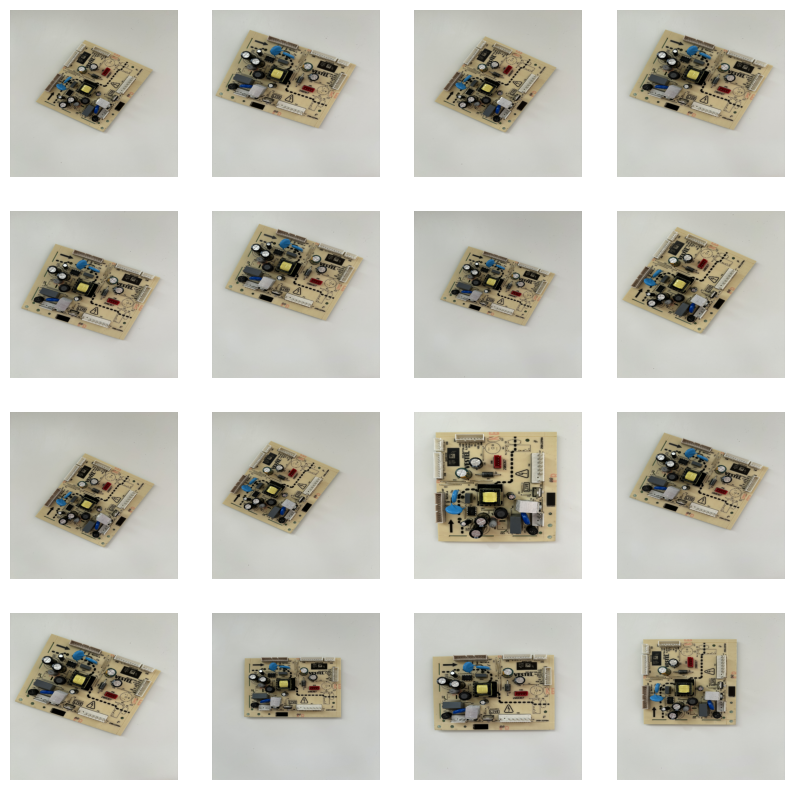

In [12]:
image_batch, _ = next(iter(train_dataset))

fig = plt.figure(figsize=(10, 10))

for index, image in enumerate(image_batch):  # Get first batch
  plt.subplot(4, 4, index + 1)
  plt.imshow(image[:, :, :])
  plt.axis('off')

### Convolutional Autoencoder Architecture

based on "*Image Based Detection of Modifications in Assembled PCBs with Deep Convolutional Autoencoders*" literature.

In [13]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling2D, UpSampling2D, Add
from tensorflow.keras.layers import LeakyReLU, Lambda, ReLU, Concatenate
from tensorflow.keras.models import Model

### Data Augmentation Layer

In [14]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  tf.keras.layers.RandomBrightness(factor=0.2, seed=None),
  tf.keras.layers.RandomContrast(0.2, seed=None)
  # tf.keras.layers.RandomCrop(256, 256, seed=None, **kwargs)
  #preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  #preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [15]:
def conv_block(x, filters=16, kernel=5, stride=2, transpose=False, slope=experiment['LRELU_SLOPE'], padding='same'):
  conv = Conv2DTranspose if transpose else Conv2D

  x = conv(filters=filters, kernel_size=(kernel,kernel), strides=stride, padding=padding, use_bias=True)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(slope)(x)

  return x

In [16]:
def create_encoder_model(input_shape, output_shape, verbose=0):
    """ input_shape: Autoencoder model input shape
        output_shape: Latent vector shape
    """
    n_leves_enc = 7
    n_dense = int(input_shape[0]/(2**n_leves_enc))

    inputs = Input(shape=input_shape, name='encoder_input')
    # Apply Data augmentation
    if experiment['DATA_AUG'] == True:
      inputs = data_augmentation(inputs)

    conv1 = conv_block(inputs, filters=32)
    conv2 = conv_block(conv1,  filters=64)
    conv3 = conv_block(conv2,  filters=128)
    conv4 = conv_block(conv3,  filters=128)
    conv5 = conv_block(conv4,  filters=256)
    conv6 = conv_block(conv5,  filters=256)
    conv7 = conv_block(conv6,  filters=256)

    conv7_flat = Flatten()(conv7)
    fc1 = Dense(units=(n_dense*n_dense*256))(conv7_flat)

    # Batch normalization
    fc1 = BatchNormalization()(fc1)
    # Add activation function Leaky ReLU
    fc1 = LeakyReLU(alpha=experiment['LRELU_SLOPE'])(fc1)

    fc2 = Dense(units=output_shape)(fc1)
    output_layer = LeakyReLU(alpha=experiment['LRELU_SLOPE'])(fc2)

    model = Model(inputs, output_layer, name='Encoder_Model')
    if verbose > 0:
      model.summary()
    return model

In [17]:
def create_decoder_model(input_shape, output_shape, verbose=0):
    """ input_shape: Latent vector shape
        output_shape: Autoencoder model input shape
    """
    n_leves_enc = 7
    n_dense = int(output_shape[0]/(2**n_leves_enc))

    inputs = Input(shape=input_shape, name='decoder_input')
    fc1 = Dense(units=(n_dense*n_dense*256))(inputs)
    fc1 = BatchNormalization()(fc1)
    fc1 = LeakyReLU(alpha=experiment['LRELU_SLOPE'])(fc1)

    z_mat = Reshape((n_dense, n_dense, 256))(fc1)

    # Transposed Convolution Layers
    dconv0 = conv_block(z_mat,  filters=256, transpose=True)
    dconv1 = conv_block(dconv0, filters=256, transpose=True)
    dconv2 = conv_block(dconv1, filters=128, transpose=True)
    dconv3 = conv_block(dconv2, filters=128, transpose=True)
    dconv4 = conv_block(dconv3, filters=64, transpose=True)
    dconv5 = conv_block(dconv4, filters=32, transpose=True)

    dconv6 = Conv2DTranspose(filters=output_shape[2], kernel_size=(5,5), strides=2, padding='same',
        use_bias=True, activation='sigmoid')(dconv5)

    model = Model(inputs, dconv6, name="Decoder_Model")
    if verbose > 0:
      model.summary()
    return model

### Create Autoencoder Model

In [18]:
encoder_model = create_encoder_model(experiment['INPUT_SHAPE'], output_shape=experiment['LATENT_DIM'], verbose=1)

Model: "Encoder_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      51264     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                    

In [19]:
latent_input = (experiment['LATENT_DIM'],)

In [20]:
create_decoder_model(latent_input, output_shape=experiment['INPUT_SHAPE'], verbose=1)

Model: "Decoder_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 500)]             0         
                                                                 
 dense_2 (Dense)             (None, 4096)              2052096   
                                                                 
 batch_normalization_8 (Bat  (None, 4096)              16384     
 chNormalization)                                                
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         1638656   
 anspose)                                            

In [21]:
def create_autoencoder_model(input_shape, latent_dim_shape):
    inputs = Input(shape=input_shape, name='Autoencoder_input')

    enc_model = create_encoder_model(input_shape, latent_dim_shape, verbose=0)
    dec_model = create_decoder_model(latent_dim_shape, input_shape, verbose=0)

    latent_vector = enc_model(inputs)
    output = dec_model(latent_vector)

    model = Model(inputs, output, name="Autoencoder_Model")

    model.summary()
    return model

In [22]:
autoencoder_model = create_autoencoder_model(experiment['INPUT_SHAPE'],
                                  latent_dim_shape=experiment['LATENT_DIM'])

Model: "Autoencoder_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Autoencoder_input (InputLa  [(None, 512, 512, 3)]     0         
 yer)                                                            
                                                                 
 Encoder_Model (Functional)  (None, 500)               23615796  
                                                                 
 Decoder_Model (Functional)  (None, 512, 512, 3)       6836803   
                                                                 
Total params: 30452599 (116.17 MB)
Trainable params: 30432247 (116.09 MB)
Non-trainable params: 20352 (79.50 KB)
_________________________________________________________________


In [23]:
def init_perceptual_loss(perp_layers, verbose=0):
  perp_model = tf.keras.applications.VGG19(input_shape=(224,224,3))
  modelOutputs = [perp_model.layers[i].output for i in perp_layers]
  model = Model(perp_model.inputs, modelOutputs)
  if verbose > 0:
      model.summary()
  return model

In [24]:
vgg19_model = init_perceptual_loss([5,8,13,18], 1)

574710816/574710816 [==============================] - 29s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [25]:
print(f'VGG19 Model layers that will be used for Perceptual Loss are: \n\
 {vgg19_model.layers[5]}\n {vgg19_model.layers[8]}\n\
 {vgg19_model.layers[13]}\n {vgg19_model.layers[18]}')

VGG19 Model layers that will be used for Perceptual Loss are: 


### MSE Perceptual Loss

Perceptual Loss

In short, the perceptual loss function works by `summing` all the `squared errors` between all the `pixels` and `taking the mean`. This is in contrast to a `per-pixel loss function` which sums all the absolute errors between pixels.


[What is a Perceptual Loss Function?](https://deepai.org/machine-learning-glossary-and-terms/perceptual-loss-function)

[Johnson et al. (2016)](https://arxiv.org/pdf/1603.08155.pdf%7C)

In [26]:
class MSE_Perceptual(tf.keras.losses.Loss):
  def __init__(self, perc_layers=[5,8,13,18], lambda_mse=0.01, lambda_perc=1, perc_loss=False):
    super(MSE_Perceptual, self).__init__()
    self.loss = None
    self.perc_layers = perc_layers
    self.lambda_mse = lambda_mse
    self.perc_loss = perc_loss
    self.lambda_perc = lambda_perc
    #with strategy.scope():  # TPU
    self.perc_model = init_perceptual_loss(self.perc_layers)
    self.loss_fn = tf.keras.losses.mean_squared_error

  def call(self, y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(tf.math.pow(y_pred,2) - tf.math.pow(y_true,2)))

    if self.perc_loss == True:
        perceptual_loss = []

        y_true_reshape = tf.image.resize(y_true, (224, 224))
        y_pred_reshape = tf.image.resize(y_pred, (224, 224))

        y_true_output = self.perc_model(y_true_reshape)
        y_pred_output = self.perc_model(y_pred_reshape)

        for idx, (y_true_layer, y_pred_layer) in enumerate(zip(y_true_output, y_pred_output)):
          w, h, d = y_pred_layer[0].shape
          perceptual_loss.append((1/(w*h*d))*tf.reduce_mean(tf.square(y_true_layer - y_pred_layer)))
          #perceptual_loss.append((1/(w*h*d))*tf.reduce_sum(tf.square(y_true_layer - y_pred_layer)))

    self.loss = self.lambda_mse*mse_loss
    if self.perc_loss == True:
        self.loss += self.lambda_perc*tf.reduce_sum(perceptual_loss)

    return self.loss

In [27]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

### Create Loss Function

In [28]:
if (experiment['RECONS_LOSS'] == 'PERCEPTUAL'):
  loss_fn = MSE_Perceptual([5,8,13,18], experiment['MSE_LOSS_LAMBDA'], experiment['PERP_LOSS_LAMBDA'], perc_loss=True)
else:
  loss_fn = MSE_Perceptual(lambda_mse=experiment['MSE_LOSS_LAMBDA'])

In [29]:
from glob import glob

training_files = glob(BD67_NORMAL_FRONT_PATH + "/*.JPG")
print(f"Number of normal BD67-PCB front side photos: {len(training_files)}")

Number of normal BD67-PCB front side photos: 76


In [30]:
from sklearn.model_selection import train_test_split

training_files, valid_files, _, _ = train_test_split(training_files, training_files, test_size=experiment['TEST_SIZE'], random_state=100)

print(f"Number of Training Images: {len(training_files)}")
print(f"Number of Validation Images: {len(valid_files)}")

Number of Training Images: 68
Number of Validation Images: 8


In [31]:
import math

training_batch_num = len(train_dataset) - math.ceil(len(train_dataset) * experiment['TEST_SIZE'])

train_dataset_part = train_dataset.take(training_batch_num)
valid_dataset_part = train_dataset.skip(training_batch_num)

print("Number of training batches:   ", len(train_dataset_part))
print("Number of validation batches: ", len(valid_dataset_part))


Number of training batches:    4
Number of validation batches:  1


### Learning Rate Decay

In [32]:
import math

LR_START = 1e-5
LR_MIN = 1e-5
#LR_MAX = 9e-4 * strategy.num_replicas_in_sync
LR_MAX = 9e-4
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = 0.5
EPOCHS = experiment['EPOCHS']

def lrfn(epoch):
  if epoch < LR_RAMPUP_EPOCHS:
    lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
  elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
    lr = LR_MAX
  else:
    progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
    lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
    if LR_MIN is not None:
      lr = tf.math.maximum(LR_MIN, lr)

  return lr

### Training Callbacks

In [33]:
lr_callback2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
cp = tf.keras.callbacks.ModelCheckpoint(filepath=f"{experiment['TRAINING_WEIGHT_DIR']}/best_model_val_loss.h5", monitor='val_loss', save_best_only=True)

In [34]:
STEPS_PER_EPOCH = len(training_files) // experiment['BATCH_SIZE']
STEPS_PER_VAL = len(valid_files) // experiment['BATCH_SIZE'] + 1

In [36]:
if experiment['TYPE'] == 'train':
    if (experiment['RECONS_LOSS'] == 'MSE') or (experiment['RECONS_LOSS'] == 'PERCEPTUAL'):
      autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(),
                              loss=loss_fn,
                              metrics=['mae', 'mse'])
    elif experiment['RECONS_LOSS'] == 'SSIM':
      autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(),
                              loss=SSIMLoss,
                              metrics=['mae', 'mse'])

In [37]:
if experiment['TYPE'] == 'train':
    autoencoder_model_hist = autoencoder_model.fit(
        train_dataset_part,
        validation_data=valid_dataset_part,
        epochs=experiment['EPOCHS'],
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[lr_callback2, cp],
        validation_steps=STEPS_PER_VAL
      )

In [ ]:
import pandas as pd

if experiment['TYPE'] == 'train':
  pd.DataFrame.from_dict(autoencoder_model_hist.history).to_csv(f"{experiment['TRAINING_WEIGHT_DIR']}/model_history.csv", index=False)

<Axes: >

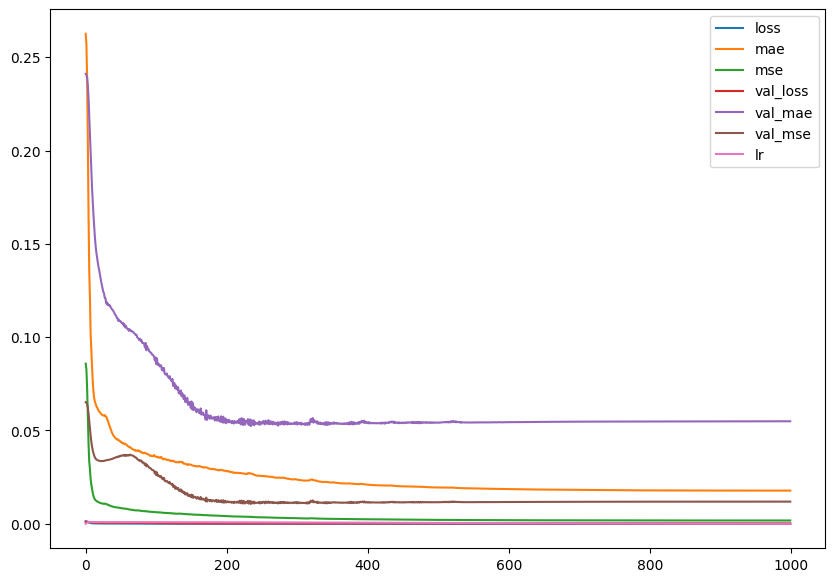

In [ ]:
if experiment['TYPE'] == 'train':
  pd.DataFrame(autoencoder_model_hist.history).plot(figsize=(10, 7))

### Run model in Inference mode - Prediction

In [78]:
def predict_perpdiff(dataset, ds_imgs, model):
  vgg19_perp_model = tf.keras.applications.VGG19(input_shape=(224,224,3))
  modelOutputs = [vgg19_perp_model.layers[i].output for i in [12]]  # Set 12th layer for the model output layer
  vgg19_perp_model = Model(vgg19_perp_model.inputs, modelOutputs)

  for ds_imgs in dataset.take(1):
    input_imgs = ds_imgs[0].numpy()

    # Predict the reconstructed image
    y_pred = model.predict(input_imgs)

    # Resize the images to the input size of VGG19
    y_true_reshape = tf.image.resize(input_imgs, (224, 224))
    y_pred_reshape = tf.image.resize(y_pred, (224, 224))
    mask1_reshape = tf.image.resize(ds_imgs[1], (224, 224))
    # mask2_reshape = tf.image.resize(ds_imgs[2], (224, 224))

    # Pass all images in the VGG19 and get the perceptual layers outputs
    perp_input = vgg19_perp_model([y_true_reshape])
    perp_pred = vgg19_perp_model([y_pred_reshape])

  # return y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred
  return y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred

In [43]:
def compute_min_max(perp_input, perp_pred):
  print("Computing min and max...")
  max_norm = 0
  min_norm = 1000000

  for img_idx in range(perp_input.shape[0]):
    perp_img = tf.math.abs( perp_input[img_idx,:,:,0] - perp_pred[img_idx,:,:,0] )

    for i in range(1, perp_input.shape[3] ):
      perp_img += tf.math.abs( perp_input[img_idx,:,:,i] - perp_pred[img_idx,:,:,i] )
      max_value = tf.math.reduce_max(perp_img)
      min_value = tf.math.reduce_min(perp_img)

      if max_value > max_norm:
        max_norm = max_value
      if min_value < min_norm:
        min_norm = min_value

  print("max_norm: {}".format(max_norm))
  print("min_norm: {}".format(min_norm))

  return min_norm, max_norm

In [45]:
def calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm):
  y_pred_all = []
  all_perp = []

  print("Calculating anomaly map")
  for img_idx in range(perp_input.shape[0]):
      perp_img = tf.math.abs(perp_input[img_idx,:,:,0] - perp_pred[img_idx,:,:,0])
      for i in range(1, perp_input.shape[3] ):
        perp_img += tf.math.abs(perp_input[img_idx,:,:,i] - perp_pred[img_idx,:,:,i])

      perp_img =(perp_img - min_norm) / (max_norm - min_norm)

      perp_img = tf.image.resize(tf.expand_dims(perp_img, axis=2), (224,224))
      perp_img = tf.squeeze(perp_img)

      all_perp.append(perp_img)
      y_pred_all.append( perp_img.numpy().ravel() )

  return all_perp, y_pred_all

In [56]:
def show_generated_images(image_batch):
  fig = plt.figure(figsize=(10, 10))
  for index, image in enumerate(image_batch):
    plt.subplot(4, 4, index + 1)
    plt.imshow(image)
    plt.axis('off')
    if index >= 15:
      break
  plt.show()

In [68]:
def display_pixel_wise_img_diff(img1_dir, img2_dir, threshold=None, verbose=0, channel=0):
  # Load your two images using TensorFlow
  #image1 = tf.image.decode_image(tf.io.read_file(img1_dir))
  #image2 = tf.image.decode_image(tf.io.read_file(img2_dir))
  image1 = img1_dir
  image2 = img2_dir

  # Ensure both images have the same shape and data type
  image1 = tf.cast(image1, tf.float32)
  image2 = tf.cast(image2, tf.float32)

  # Compute pixel-wise absolute differences
  diff = tf.abs(image1 - image2)
  if verbose > 0:  print(f"Difference map shape: {diff.shape}")

  # Define a colormap (e.g., 'jet') and normalize the differences
  cmap = plt.get_cmap('jet')
  norm = plt.Normalize(vmin=0, vmax=tf.reduce_max(diff).numpy())
  norm_diff = norm(diff)
  if verbose > 0:
    print(f"Normalized difference map shape: {norm_diff.shape}")
    print(f"Normalized difference map min, avg, max value: ({np.min(norm_diff)}, {np.mean(norm_diff):.5f}, {np.max(norm_diff)})")

  colored_diff = cmap(norm_diff)
  if verbose > 0:  print(f"Colored difference map shape: {colored_diff.shape}")

  color_diff_plot = colored_diff[:, :, :,channel]

  if threshold != None:
    color_diff_plot[color_diff_plot < threshold] = 0.0

  # Display the color-coded difference map
  plt.imshow(color_diff_plot)
  plt.colorbar()
  plt.axis('off')
  plt.show()

Load trained weights

In [38]:
if experiment['TYPE'] == 'test':
  autoencoder_model.load_weights('/content/drive/MyDrive/MASTER/Master_Thesis/Google_Colab_Workspace/BD67_weights/weights_data_aug_True_bath_size_16_epochs_1000_loss_mse_perc/best_model_val_loss.h5')

Run the model in Inference mode and try it on training data

### Generate Images from Training Data

4/4 [==============================] - 0s 108ms/step


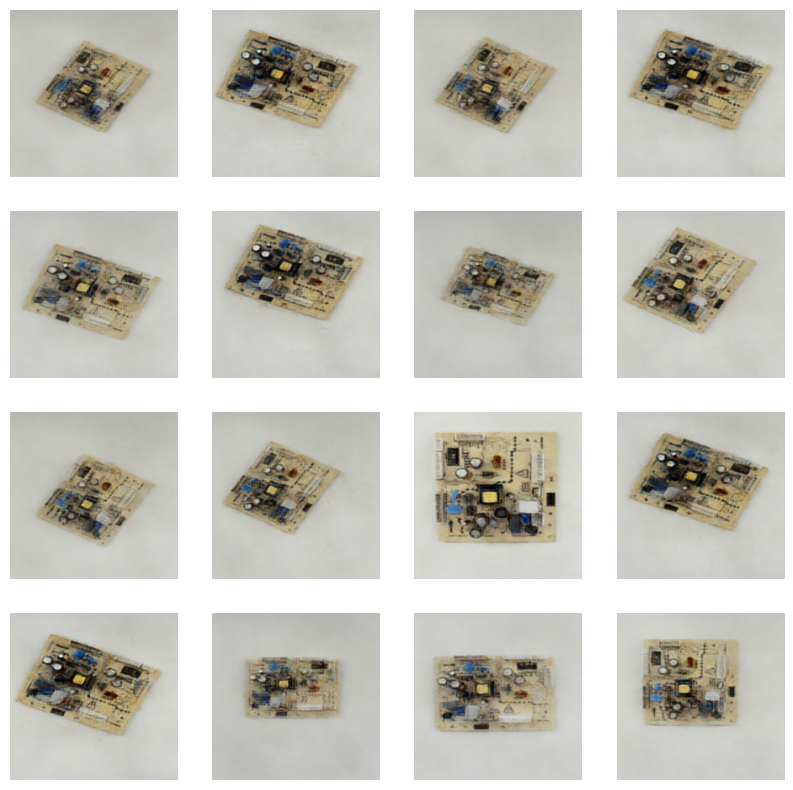

In [57]:
generated_train_data = autoencoder_model.predict(train_dataset_part)

show_generated_images(generated_train_data)

Difference map shape: (512, 512, 3)
Normalized difference map shape: (512, 512, 3)
Normalized difference map min, avg, max value: (0.0, 0.02985, 1.0)
Colored difference map shape: (512, 512, 3, 4)


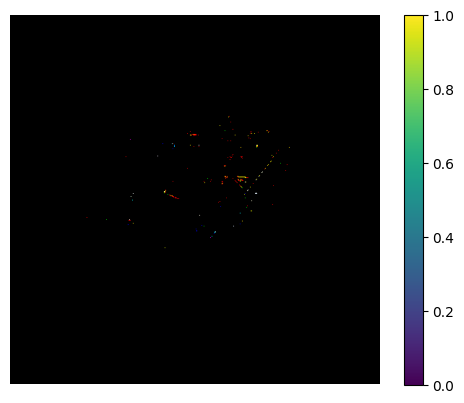

In [76]:
train_batch, _ = next(iter(train_dataset_part))

display_pixel_wise_img_diff(train_batch[0], generated_train_data[0], threshold=0.8, channel=0, verbose=1)

1/1 [==============================] - 0s 87ms/step
Computing min and max...
max_norm: 3101.670166015625
min_norm: 0.0
Calculating anomaly map


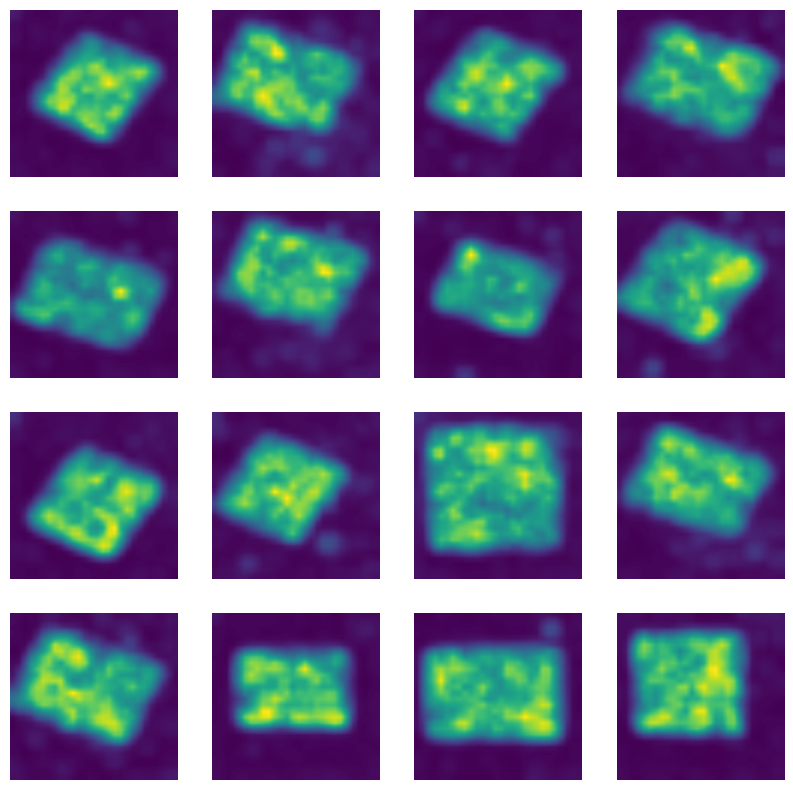

In [79]:
# Predict all images for training data
# y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred = predict_perpdiff(test_dataset, autoencoder_model)
y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred = predict_perpdiff(train_dataset, train_dataset_part, autoencoder_model)

# Get min max for normalization
min_norm, max_norm = compute_min_max(perp_input, perp_pred)

# Calculate perceptual anomaly map
all_perp, y_pred_all = calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm)
show_generated_images(all_perp)

### Generate Images from Validation Data

1/1 [==============================] - 0s 15ms/step


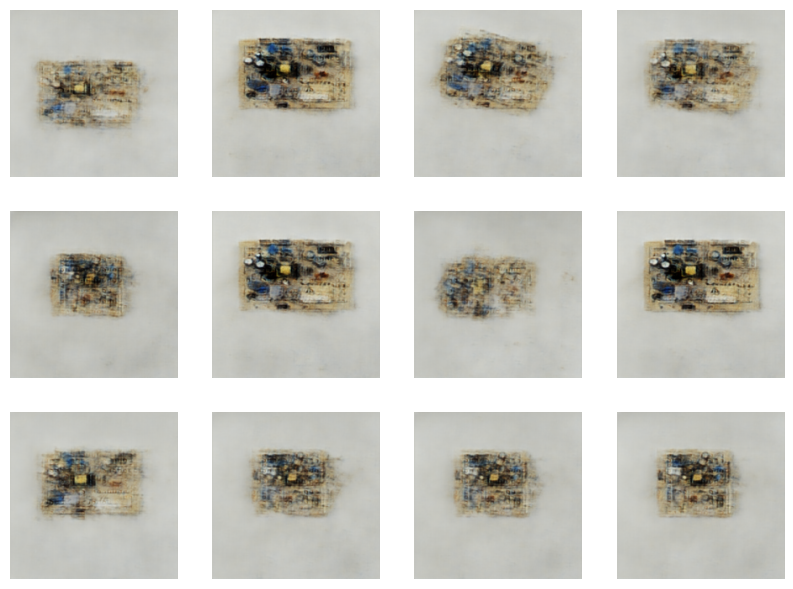

In [58]:
generated_valid_data = autoencoder_model.predict(valid_dataset_part)

show_generated_images(generated_valid_data)

Difference map shape: (512, 512, 3)
Normalized difference map shape: (512, 512, 3)
Normalized difference map min, avg, max value: (6.222755644103017e-08, 0.05541, 1.0)
Colored difference map shape: (512, 512, 3, 4)


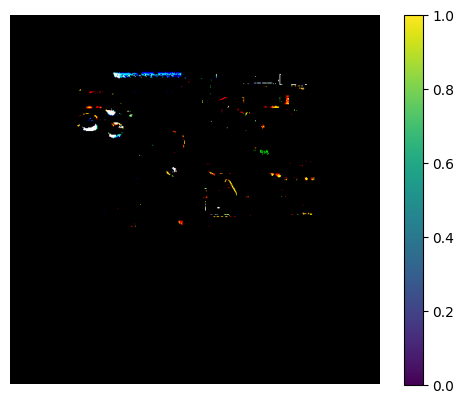

In [84]:
valid_batch, _ = next(iter(valid_dataset_part))

display_pixel_wise_img_diff(valid_batch[1], generated_valid_data[1], threshold=0.8, channel=0, verbose=1)

1/1 [==============================] - 0s 53ms/step
Computing min and max...
max_norm: 6051.72021484375
min_norm: 0.0
Calculating anomaly map


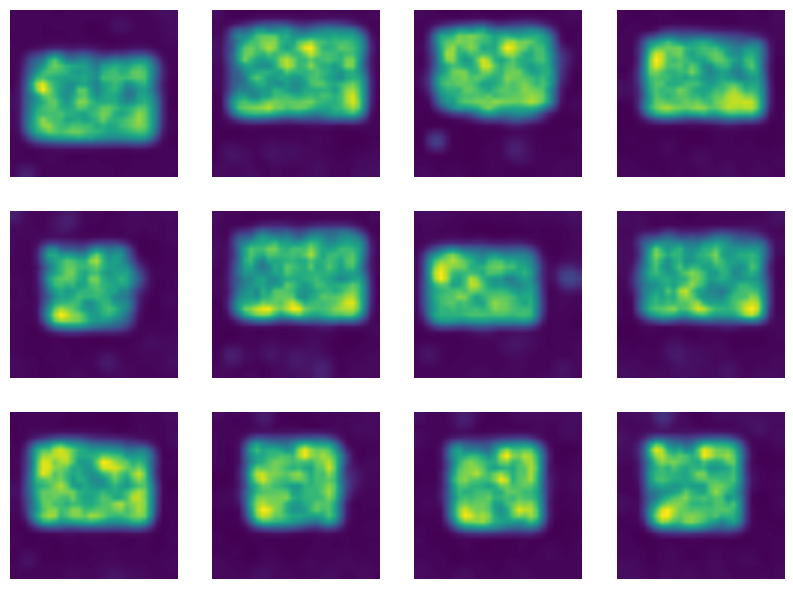

In [86]:
# Predict all images for training data
# y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred = predict_perpdiff(test_dataset, autoencoder_model)
y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred = predict_perpdiff(valid_dataset_part, valid_dataset_part, autoencoder_model)

# Get min max for normalization
min_norm, max_norm = compute_min_max(perp_input, perp_pred)

# Calculate perceptual anomaly map
all_perp, y_pred_all = calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm)
show_generated_images(all_perp)

Create Test Dataset

In [87]:
import glob
test_dataset = create_dataset_pipeline(BD67_DEFECTED_FRONT_PATH)

### Generate Images from Testing Data

1/1 [==============================] - 0s 50ms/step


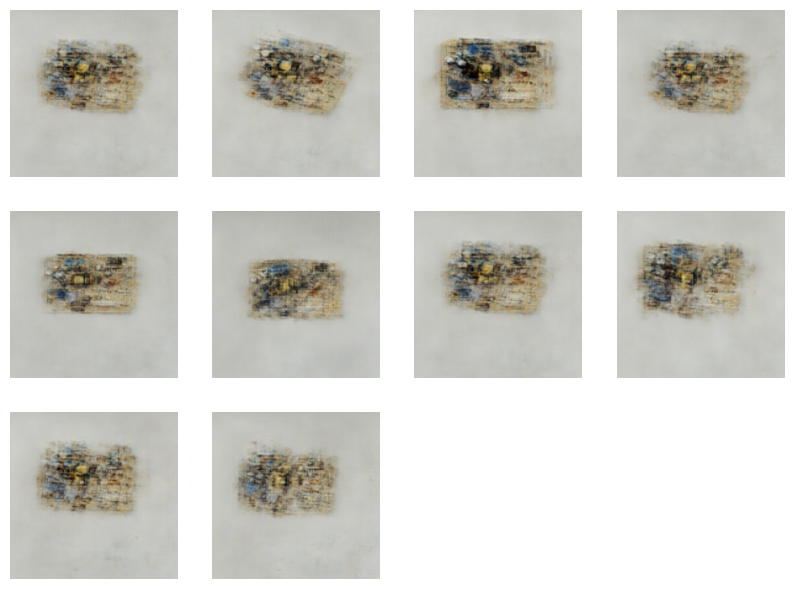

In [88]:
generated_test_data = autoencoder_model.predict(test_dataset)

show_generated_images(generated_test_data)

Difference map shape: (512, 512, 3)
Normalized difference map shape: (512, 512, 3)
Normalized difference map min, avg, max value: (6.069390678931086e-08, 0.05629, 1.0)
Colored difference map shape: (512, 512, 3, 4)


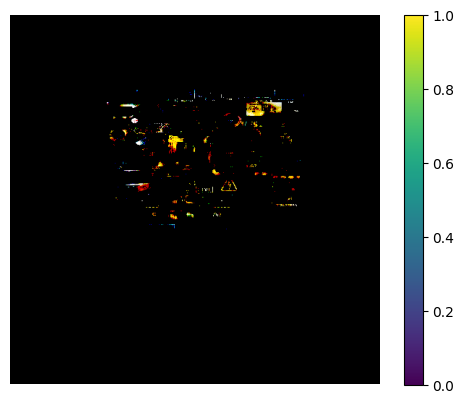

In [90]:
test_batch, _ = next(iter(test_dataset))

display_pixel_wise_img_diff(test_batch[1], generated_test_data[1], threshold=0.6, channel=0, verbose=1)

1/1 [==============================] - 0s 62ms/step
Computing min and max...
max_norm: 5913.9482421875
min_norm: 0.0
Calculating anomaly map


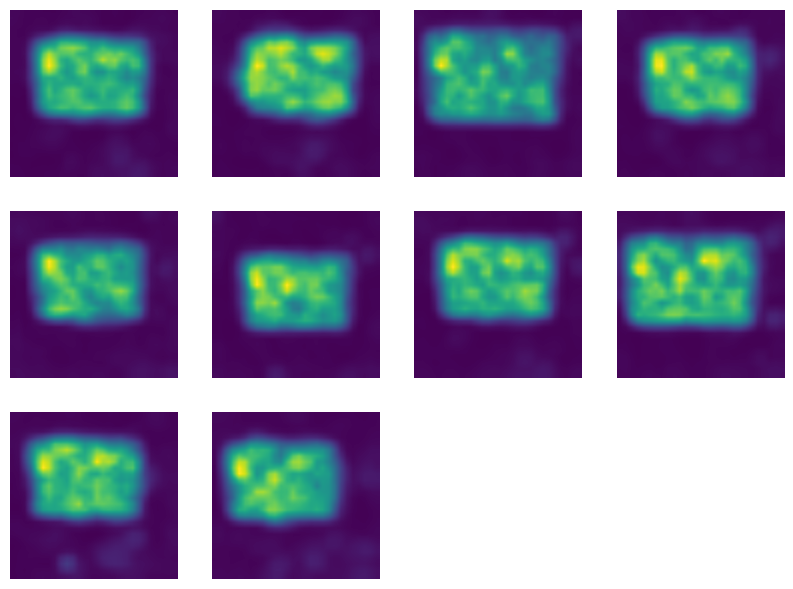

In [92]:
# Predict all images
# y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred = predict_perpdiff(test_dataset, autoencoder_model)
y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred = predict_perpdiff(test_dataset, test_dataset, autoencoder_model)

# Get min max for normalization
min_norm, max_norm = compute_min_max(perp_input, perp_pred)

# Calculate perceptual anomaly map
all_perp, y_pred_all = calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm)
show_generated_images(all_perp)